In [ ]:
!wget https://raw.githubusercontent.com/harsha711/sensitive-content-classification/main/text_dataset/annotation_results.csv

--2023-03-26 07:24:04--  https://raw.githubusercontent.com/harsha711/sensitive-content-classification/main/text_dataset/annotation_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 952650 (930K) [text/plain]
Saving to: ‘annotation_results.csv’

annotation_results. 100%[===================>] 930.32K  --.-KB/s    in 0.02s   

2023-03-26 07:24:04 (55.7 MB/s) - ‘annotation_results.csv’ saved [952650/952650]



In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model, backend, utils
from tensorflow.keras.layers import Layer, Conv1D, LSTM, Bidirectional, MaxPooling1D, Dropout, Input, Embedding, Attention, AdditiveAttention, GlobalAveragePooling1D, Dense, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


import pandas as pd
import numpy as np

import re
import string

import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from google.colab import drive

#from official.nlp import optimization

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df = pd.read_csv("/content/annotation_results.csv", index_col='uri')
# df = pd.read_csv("/content/mixed dataset.csv")
# df = df.sample(frac=1).reset_index(drop=True)
df

,text,Incomprensibile,Non sensibile,Non so,Sensibile
uri,,,,,
0,likes the sound of thunder.,0,2,0,1
1,is so sleepy it's not even funny that's she ca...,0,1,0,2
2,is sore and wants the knot of muscles at the b...,0,0,0,3
3,likes how the day sounds in this new song.,0,2,1,0
4,is home. <3,0,0,0,3
...,...,...,...,...,...
9912,little things give you away.,0,2,1,0
9913,is wishing it was Saturday.,0,3,0,0
9914,is studying hard for the G.R.E.,0,2,1,0


In [ ]:
df["class"] = np.where(df["Sensibile"]>=2, 1, 0)
df.head()

,text,Incomprensibile,Non sensibile,Non so,Sensibile,class
uri,,,,,,
0,likes the sound of thunder.,0,2,0,1,0
1,is so sleepy it's not even funny that's she ca...,0,1,0,2,1
2,is sore and wants the knot of muscles at the b...,0,0,0,3,1
3,likes how the day sounds in this new song.,0,2,1,0,0
4,is home. <3,0,0,0,3,1


# Data Cleaning

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
contractions = contraction_mapping

#initialize stop words and LancasterStemmer
stop_words=set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def text_cleaning(x, remove_emojis=True, remove_stop_words=True):
    """Apply function to a clean a tweet"""
    x = x.lower().strip()
    # romove urls
    # url = re.compile(r'https?://\S+|www\.\S+')
    # x = url.sub(r'',x)
    # remove html tags
    html = re.compile(r'<.*?>')
    x = html.sub(r'',x)
    #contractions
    x = ' '.join([contraction_mapping[w] if w in contraction_mapping else w for w in x.split(' ')])
    #print(temp)
    # remove punctuation
    # replacing_value = len(string.punctuation) * ' '
    # operator = str.maketrans(string.punctuation, replacing_value) #????
    # x = x.translate(operator)
    x = re.sub(r'[^\w\s]', '', x)
    x = x.rstrip()
    if remove_emojis:
        x = x.encode('ascii', 'ignore').decode('utf8').strip()
    if remove_stop_words:
        #x = ' '.join([lemmatizer.lemmatize(word) for word in x.split(' ') if word not in stop_words])
        x = ' '.join([word for word in x.split(' ')])
    return x

In [ ]:
df['cleaned_text'] = df['text'].apply(text_cleaning)
df

,text,Incomprensibile,Non sensibile,Non so,Sensibile,class,cleaned_text
uri,,,,,,,
0,likes the sound of thunder.,0,2,0,1,0,likes the sound of thunder
1,is so sleepy it's not even funny that's she ca...,0,1,0,2,1,is so sleepy it is not even funny that is she ...
2,is sore and wants the knot of muscles at the b...,0,0,0,3,1,is sore and wants the knot of muscles at the b...
3,likes how the day sounds in this new song.,0,2,1,0,0,likes how the day sounds in this new song
4,is home. <3,0,0,0,3,1,is home 3
...,...,...,...,...,...,...,...
9912,little things give you away.,0,2,1,0,0,little things give you away
9913,is wishing it was Saturday.,0,3,0,0,0,is wishing it was saturday
9914,is studying hard for the G.R.E.,0,2,1,0,0,is studying hard for the gre


In [ ]:
df = df.sample(frac=1, random_state=42)

In [ ]:
df

,text,Incomprensibile,Non sensibile,Non so,Sensibile,class,cleaned_text
uri,,,,,,,
6556,had a really really good day,0,2,0,1,0,had a really really good day
9285,"Finally, a three day weekend to.... catch up w...",0,1,0,2,1,finally a three day weekend to catch up with s...
360,How do i change my name??,0,3,0,0,0,how do i change my name
1261,had everything go wrong for dinner tonight but...,0,1,0,2,1,had everything go wrong for dinner tonight but...
3038,Thinks that chrome has come a long way since t...,0,3,0,0,0,thinks that chrome has come a long way since t...
...,...,...,...,...,...,...,...
5734,Snow in Germany!,0,2,1,0,0,snow in germany
5191,just saw a commercial for Rihanna's 20//20 int...,0,2,1,0,0,just saw a commercial for rihannas 2020 interv...
5390,is sick?,0,0,1,2,1,is sick


# Tokenization

In [ ]:
max_text_len = 0
# for text in df["text"].head():
#   print(len(text.split()))
for text in df["cleaned_text"]:
  # if type(text) == float:
  #   print(text)
  text = str(text)
  max_text_len = max(len(text.split()), max_text_len)
print(max_text_len)

91


In [ ]:
vocab_size = 10000
oov_tok = "<OOV>"
maxlen = max_text_len
trunc_type="post"
padding_type="post"
embedding_dim = 100 #50


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_text"], df["class"], test_size=0.15, stratify=df["class"],random_state = 7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,random_state = 7)

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,
                      oov_token = oov_tok)

In [ ]:
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index
print(dict(list(words_to_index.items())[:10]))
print(len(words_to_index))

{'<OOV>': 1, 'the': 2, 'to': 3, 'is': 4, 'i': 5, 'a': 6, 'and': 7, 'of': 8, 'in': 9, 'for': 10}
13816


In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences,
                                maxlen=maxlen,
                                padding=padding_type,
                                truncating = trunc_type)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences,
                                maxlen=maxlen,
                                padding=padding_type,
                                truncating = trunc_type)

X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_sequences,
                                maxlen=maxlen,
                                padding=padding_type,
                                truncating = trunc_type)

# Defining Glove Function and parameters

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)



  return word_to_vec_map

In [ ]:
word_to_vec_map = read_glove_vector('/content/drive/My Drive/capstone/glove/glove.twitter.27B.50d.txt')

In [ ]:
#vocab_len = vocab_size
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['password'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))


for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None and index < vocab_len:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len,
                            output_dim=embed_vector_len,
                            input_length=maxlen,
                            weights = [emb_matrix],
                            trainable=False)

# Positional Embedding

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[emb_matrix])
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


# Definition of Multihead Attention Transformer Block

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        #print(inputs)
        attn_output = self.att(inputs, inputs)
        #print(attn_output)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# Defining callbacks

In [ ]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=0, mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-6, mode='max')

# Plotting graph method

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


# Method to calculate validation results

In [ ]:
def calculate_results(y_true, y_pred):

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

# LSTM-Multihead Attention

In [ ]:
embed_dim = 50
num_heads = 8
ff_dim = 32

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_len, embed_dim)
x = embedding_layer(inputs)
# x = Conv1D(8, 3, padding="same", activation='relu')(x)
# x = Dropout(0.6)(x)
# #x = MaxPooling1D()(x)
# x = Conv1D(16, 3, padding="same", activation='relu')(x)
# x = Dropout(0.6)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.7)(x)
x = LSTM(embed_dim, return_sequences=True)(x)
#x = Dropout(0.7)(x)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_padded, y_train, epochs=40, validation_data=(X_test_padded, y_test),
    callbacks=[reduce_lr_acc, earlyStopping]
)


Epoch 1/40
224/224 [==============================] - 40s 112ms/step - loss: 0.6035 - accuracy: 0.6887 - val_loss: 0.4986 - val_accuracy: 0.7628 - lr: 0.0010
Epoch 2/40
224/224 [==============================] - 11s 47ms/step - loss: 0.4995 - accuracy: 0.7584 - val_loss: 0.4915 - val_accuracy: 0.7238 - lr: 0.0010
Epoch 3/40
224/224 [==============================] - 6s 28ms/step - loss: 0.4483 - accuracy: 0.7901 - val_loss: 0.4868 - val_accuracy: 0.7675 - lr: 0.0010
Epoch 4/40
224/224 [==============================] - 8s 34ms/step - loss: 0.3985 - accuracy: 0.8226 - val_loss: 0.4885 - val_accuracy: 0.7634 - lr: 0.0010
Epoch 5/40
224/224 [==============================] - 5s 24ms/step - loss: 0.3297 - accuracy: 0.8562 - val_loss: 0.5890 - val_accuracy: 0.7796 - lr: 0.0010
Epoch 6/40
224/224 [==============================] - 7s 33ms/step - loss: 0.2718 - accuracy: 0.8872 - val_loss: 0.5819 - val_accuracy: 0.7574 - lr: 0.0010
Epoch 7/40
224/224 [==============================] - 5s 21ms

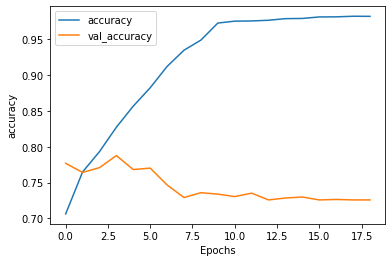

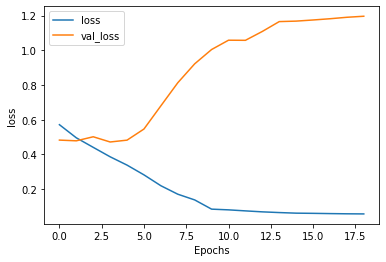

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
y_preds = np.round(model.predict(X_val_padded))
results = calculate_results(y_true= y_val, y_pred=y_preds)
print(results)

40/40 [==============================] - 1s 8ms/step
{'accuracy': 0.733596837944664, 'precision': 0.7331365837272226, 'recall': 0.733596837944664, 'f1': 0.7333624855554216}


In [ ]:
name="history_lstm_multihead.txt"
with open(name, 'w+') as f:
  for value in history.history["accuracy"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")
  for value in history.history["val_accuracy"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")
  for value in history.history["loss"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")
  for value in history.history["val_loss"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")

f.close()



# CNN-LSTM-Multihead Attention

In [ ]:
embed_dim = 50
num_heads = 8
ff_dim = 128

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_len, embed_dim)
x = embedding_layer(inputs)
x = Conv1D(8, 3, padding="same", activation='relu')(x)
x = Dropout(0.5)(x)
#x = MaxPooling1D()(x)
x = Conv1D(16, 3, padding="same", activation='relu')(x)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.7)(x)
x = LSTM(embed_dim, return_sequences=True)(x)
#x = Dropout(0.7)(x)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


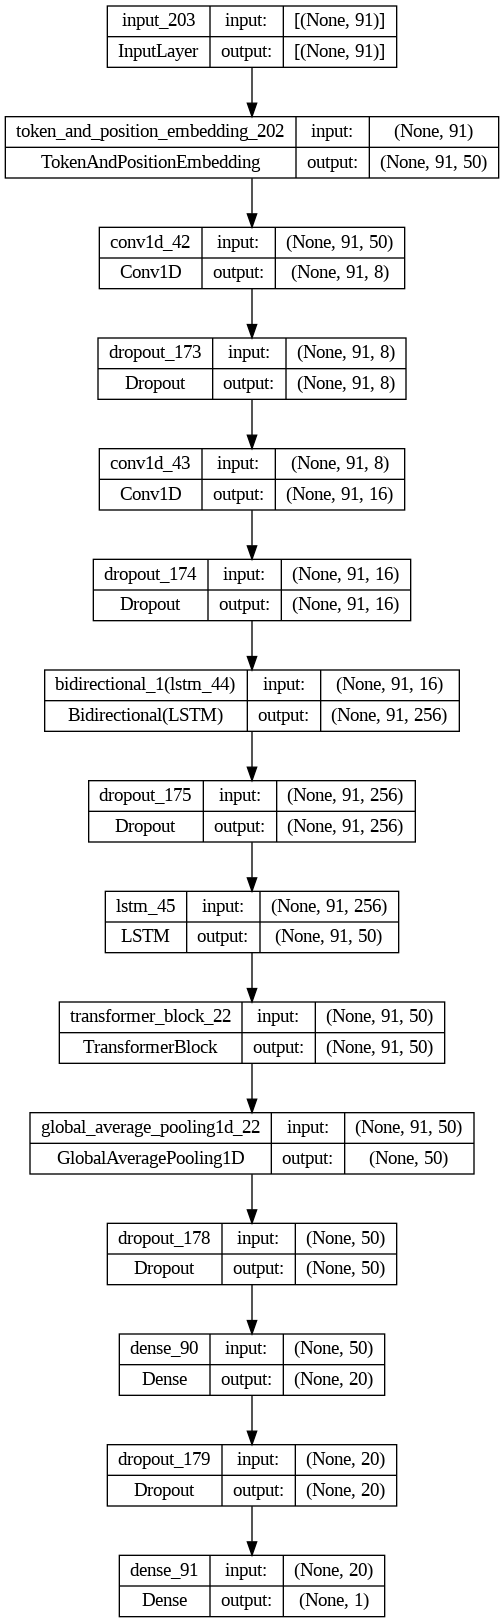

In [ ]:
utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_padded, y_train, epochs=40, validation_data=(X_test_padded, y_test),
    callbacks=[reduce_lr_acc, earlyStopping]
)


Epoch 1/40
224/224 [==============================] - 30s 92ms/step - loss: 0.6370 - accuracy: 0.6582 - val_loss: 0.5908 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 2/40
224/224 [==============================] - 10s 43ms/step - loss: 0.5861 - accuracy: 0.6731 - val_loss: 0.5322 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 3/40
224/224 [==============================] - 6s 28ms/step - loss: 0.5354 - accuracy: 0.7252 - val_loss: 0.4971 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 4/40
224/224 [==============================] - 7s 30ms/step - loss: 0.4885 - accuracy: 0.7652 - val_loss: 0.5015 - val_accuracy: 0.7507 - lr: 0.0010
Epoch 5/40
224/224 [==============================] - 6s 26ms/step - loss: 0.4593 - accuracy: 0.7852 - val_loss: 0.4702 - val_accuracy: 0.7823 - lr: 0.0010
Epoch 6/40
224/224 [==============================] - 6s 27ms/step - loss: 0.4196 - accuracy: 0.8137 - val_loss: 0.5098 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 7/40
224/224 [==============================] - 7s 31ms/

# Saving the hybrid model

In [ ]:
model.save("/content/drive/My Drive/capstone/saved_models/cnn_lstm_multihead_model")

In [ ]:
y_preds = np.round(model.predict(X_val_padded))
results = calculate_results(y_true= y_val, y_pred=y_preds)
print(results)

40/40 [==============================] - 2s 12ms/step
{'accuracy': 0.7644268774703558, 'precision': 0.75815950752614, 'recall': 0.7644268774703558, 'f1': 0.7591585568273742}


In [ ]:
name="history_cnn_lstm_multihead.txt"
with open(name, 'w+') as f:
  for value in history.history["accuracy"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")
  for value in history.history["val_accuracy"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")
  for value in history.history["loss"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")
  for value in history.history["val_loss"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")

f.close()



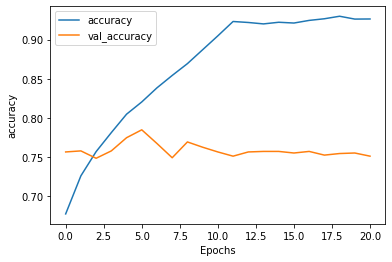

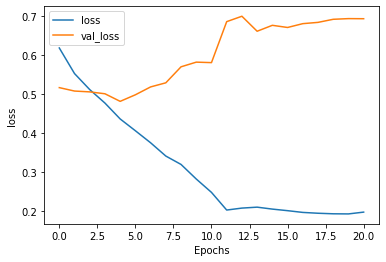

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Hyperparameter Tuning

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
def create_cnn_lstm_multihead_attention_model(units, rate, filters, head, ff):
  embed_dim = 50
  num_heads = head
  ff_dim = ff

  inputs = layers.Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_len, embed_dim)
  x = embedding_layer(inputs)
  x = Conv1D(filters, 3, padding="same", activation='relu')(x)
  x = Dropout(rate)(x)
  x = MaxPooling1D(3)(x)
  x = Conv1D(2*filters, 3, padding="same", activation='relu')(x)
  x = Dropout(rate)(x)
  x = LSTM(units, return_sequences=True)(x)
  x = Dropout(rate)(x)
  x = LSTM(embed_dim, return_sequences=True)(x)
  x = Dropout(rate)(x)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(20, activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

  return model

In [ ]:
hybrid_model = KerasClassifier(create_cnn_lstm_multihead_attention_model,
                        epochs=15,
                        verbose=1,
                        validation_split=0.2,
                        #callbacks=[earlyStopping]
                        )

In [ ]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [ ]:
param_grid_hybrid_model = dict(
    model__units = [64, 32, 16],
    model__rate = [0.4, 0.5, 0.6, 0.7],
    model__filters = [8, 16, 32],
    model__head = [4, 6, 8],
    model__ff = [32, 64, 128]
)

In [ ]:
grid_hybrid = RandomizedSearchCV(hybrid_model, param_grid_hybrid_model, cv=4, verbose=1, n_iter=5, scoring="accuracy")

In [ ]:
"grid_result_hybrid = grid_hybrid.fit(X_train_padded, y_train)

ValueError: ignored

In [ ]:
print(grid_hybrid.best_score_, grid_hybrid.best_params_)

In [ ]:
# intermediate_layer_model2 = Model(inputs=model.input,
#                                  outputs=model.layers[2].output)

# intermediate_layer_model1 = Model(inputs=model.input,
#                                  outputs=model.layers[1].output)

attention_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer("transformer_block").output)

def show(sentences):
    fig, axn = plt.subplots(len(sentences), 1)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=5, hspace=10)
    fig.tight_layout()

    for i, ax in enumerate(axn.flat):
        seq = sentences[i]
        words = seq.split(" ")
        arr = np.zeros(maxlen)
        for j in range(len(words)):
            if words[j] in words_to_index:
                arr[j] = words_to_index[words[j].lower()]
            else:
                arr[j] = words_to_index["<OOV>"]

        arr = np.reshape(arr, (1, arr.shape[0]))
        # intermediate_output2 = intermediate_layer_model2.predict(arr, verbose=0)
        # intermediate_output1 = intermediate_layer_model1.predict(arr, verbose=0)
        attention_output = attention_layer_model.predict(arr, verbose=0)
        print(seq, model.predict(arr))

        weights = attention_output
        val = []
        total = 0
        for j in range(len(words)):
            val.append(weights[0][j][0])
            total += weights[0][j][0]

        d = {}
        print(val)
        d[""] = pd.Series(val, index=words)

        df = pd.DataFrame(d)
        df.reindex(sentences[i].split(" "))
        df = df.transpose()

    #     sns.heatmap(df, ax=ax, annot=False, linewidths=.0, cbar_ax=cbar_ax if i else cbar_ax, cmap="RdBu_r",#"YlGnBu",
    #                   cbar_kws={"orientation": "vertical"})
        sns.heatmap(df, ax=ax, annot=False, cbar_ax=None, cbar=False, linewidths=.0, cmap="YlGnBu")#"Oranges")#"RdBu_r")

    return fig

1/1 [==============================] - 0s 23ms/step
I lost my wallet nearby the post office. [[0.01353104]]
[-0.58988816, -0.7569545, -0.6119304, -0.49191496, -0.48403105, -0.4801432, -0.48018357, -0.48052078]
1/1 [==============================] - 0s 30ms/step
Royce is studying for his finals. [[0.1915264]]
[-1.5721409, -1.6529386, -1.770656, -1.8646966, -1.9153967, -1.9307082]
1/1 [==============================] - 0s 23ms/step
luca won 3 millions dollars in a lottery [[0.0097444]]
[-0.42572924, -0.33827108, -0.24289931, -0.20373937, -0.18096504, -0.16992316, -0.16888763, -0.17299336]
1/1 [==============================] - 0s 21ms/step
I am going to reach home in 3 hours. [[0.804129]]
[0.06557348, 0.97339463, 1.0240303, 1.028125, 0.99696594, 0.95031226, 0.8963167, 0.84151536, 0.7920011]
1/1 [==============================] - 0s 25ms/step
I am going to meet Ryan today at 6. [[0.8533132]]
[0.88167775, 1.0492792, 1.0855036, 1.0827032, 1.056495, 1.0194975, 0.9750919, 0.92771673, 0.882373

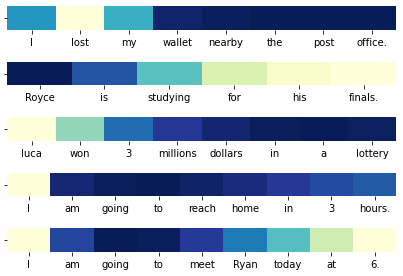

In [ ]:
sentences = ["I lost my wallet nearby the post office.",
             "Royce is studying for his finals.",
             "luca won 3 millions dollars in a lottery",
             "I am going to reach home in 3 hours.",
             "I am going to meet Ryan today at 6."
             ]

figure = None
figure = show(sentences)
#figure.savefig('graphs/stressed.pdf', format='pdf', dpi=300)

# Single head attention mechanism

In [ ]:
enc_inputs = Input(shape=(maxlen,), name='enc_inputs')
embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)(enc_inputs)

cnn = Conv1D(16, 3, padding="same", activation="relu")(embedding)

whole_sequence = LSTM(128, recurrent_dropout=0.4, return_sequences=True)(cnn)

query_value_attention_seq = Attention()([whole_sequence, whole_sequence])

encoder = Model(enc_inputs, query_value_attention_seq, name='encoder')

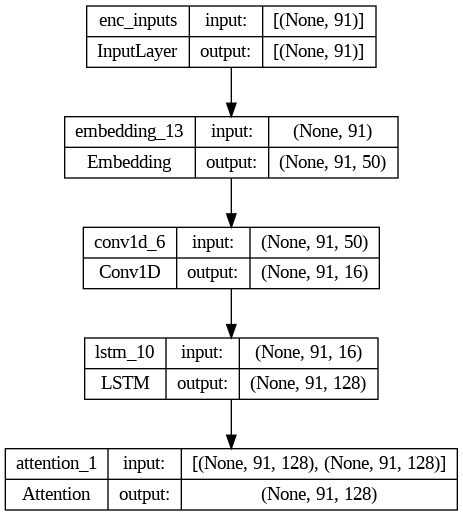

In [ ]:
utils.plot_model(encoder, show_shapes=True)

In [ ]:
dec_input = Input(shape=(maxlen, 128), name='dec_inputs')

cnn = Conv1D(16, 3, padding="same", activation="relu")(dec_input)

whole_sequence = LSTM(128, recurrent_dropout=0.4, return_sequences=True)(cnn)

# Query-value attention of shape [batch_size, Tq, filters].
query_value_attention_seq = AdditiveAttention()([whole_sequence, dec_input])

# Reduce over the sequence axis to produce encodings of shape
# [batch_size, filters].
query_value_attention = GlobalAveragePooling1D()(query_value_attention_seq)

dec_output = Dense(1, activation='sigmoid')(query_value_attention)

# build decoder model
decoder = Model(dec_input, dec_output, name='decoder')

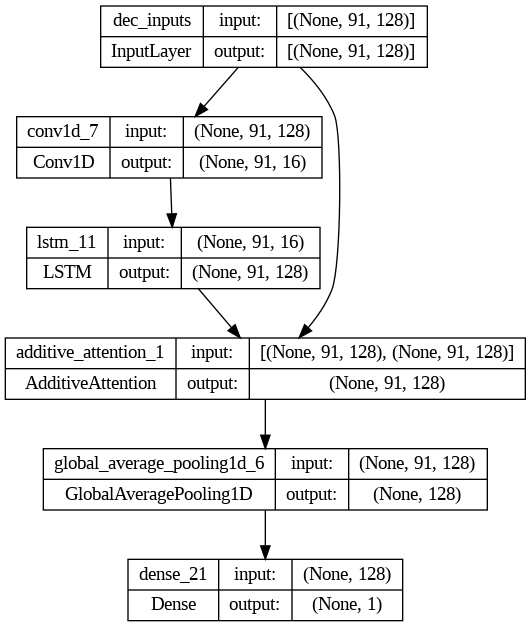

In [ ]:
utils.plot_model(decoder, show_shapes=True)

(None, 91, 128)
(None, 1)


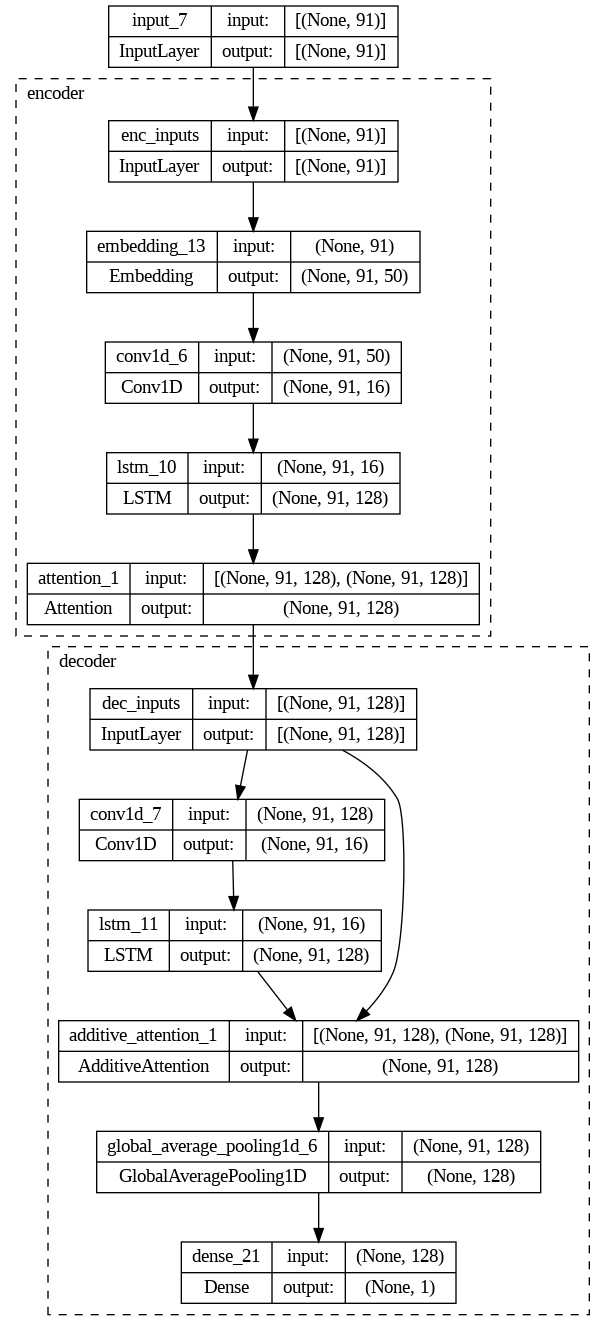

In [ ]:
# encoder
encoder_init = Input(shape=(maxlen, ))
encoder_output = encoder(encoder_init); print(encoder_output.shape)

# decoder
decoder_output = decoder(encoder_output); print(decoder_output.shape)

# bind all: autoencoder
autoencoder = Model(encoder_init, decoder_output)

# check layout
utils.plot_model(autoencoder, show_shapes=True, expand_nested=True)

In [ ]:
autoencoder.compile('adam', 'binary_crossentropy', metrics=["accuracy"])
history_autoencoder = autoencoder.fit(
    X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test), callbacks=[reduce_lr_acc, earlyStopping]
)


Epoch 1/10
224/224 [==============================] - 197s 850ms/step - loss: 0.6214 - accuracy: 0.6774 - val_loss: 0.5195 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 2/10
224/224 [==============================] - 173s 775ms/step - loss: 0.4651 - accuracy: 0.7874 - val_loss: 0.5039 - val_accuracy: 0.7634 - lr: 0.0010
Epoch 3/10
224/224 [==============================] - 165s 738ms/step - loss: 0.3491 - accuracy: 0.8597 - val_loss: 0.5265 - val_accuracy: 0.7601 - lr: 0.0010
Epoch 4/10
224/224 [==============================] - 166s 739ms/step - loss: 0.2677 - accuracy: 0.8973 - val_loss: 0.6282 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 5/10
224/224 [==============================] - 165s 736ms/step - loss: 0.2136 - accuracy: 0.9217 - val_loss: 0.6750 - val_accuracy: 0.7372 - lr: 0.0010
Epoch 6/10
224/224 [==============================] - 168s 750ms/step - loss: 0.1575 - accuracy: 0.9437 - val_loss: 0.7354 - val_accuracy: 0.7231 - lr: 0.0010
Epoch 7/10
224/224 [==========================

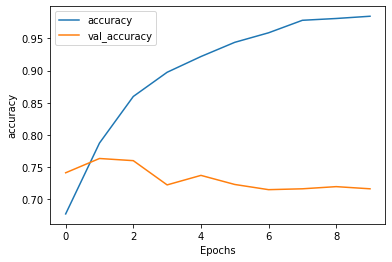

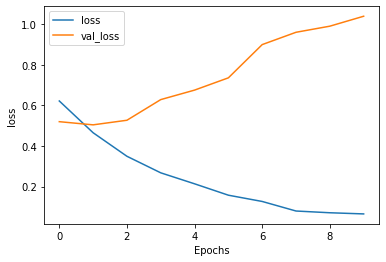

In [ ]:
plot_graphs(history_autoencoder, "accuracy")
plot_graphs(history_autoencoder, "loss")

In [ ]:
name="history_cnn_lstm_single_att.txt"
with open(name, 'w+') as f:
  for value in history_autoencoder.history["accuracy"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")
  for value in history_autoencoder.history["val_accuracy"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")
  for value in history_autoencoder.history["loss"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")
  for value in history_autoencoder.history["val_loss"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")

f.close()



In [ ]:
y_preds_2 = np.round(autoencoder.predict(X_val_padded))
results_2 = calculate_results(y_true= y_val, y_pred=y_preds_2)
print(results_2)

40/40 [==============================] - 6s 119ms/step
{'accuracy': 0.7177865612648221, 'precision': 0.7176229490388775, 'recall': 0.7177865612648221, 'f1': 0.7177042999555352}


# Multihead Attention Mechanism


In [ ]:
class TokenAndPositionEmbeddingWithoutGlove(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [ ]:
embed_dim = 8  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 8  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbeddingWithoutGlove(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(10, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model2 = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history2 = model2.fit(
    X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test), callbacks=[reduce_lr_acc, earlyStopping]
)


Epoch 1/10
224/224 [==============================] - 31s 94ms/step - loss: 0.6384 - accuracy: 0.6608 - val_loss: 0.6184 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 2/10
224/224 [==============================] - 6s 26ms/step - loss: 0.6112 - accuracy: 0.6776 - val_loss: 0.5732 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 3/10
224/224 [==============================] - 4s 18ms/step - loss: 0.5193 - accuracy: 0.7465 - val_loss: 0.6097 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 4/10
224/224 [==============================] - 4s 16ms/step - loss: 0.4316 - accuracy: 0.8085 - val_loss: 0.5098 - val_accuracy: 0.7554 - lr: 0.0010
Epoch 5/10
224/224 [==============================] - 3s 13ms/step - loss: 0.3449 - accuracy: 0.8554 - val_loss: 0.5521 - val_accuracy: 0.7520 - lr: 0.0010
Epoch 6/10
224/224 [==============================] - 3s 12ms/step - loss: 0.2754 - accuracy: 0.8928 - val_loss: 0.6455 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 7/10
224/224 [==============================] - 4s 16ms/s

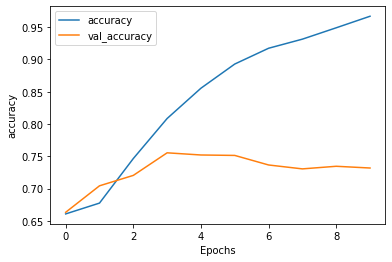

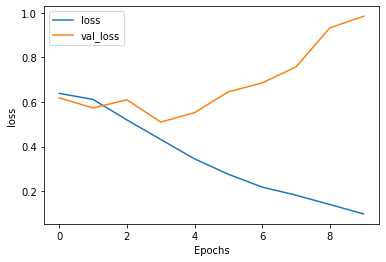

In [ ]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

In [ ]:
y_preds_3 = np.round(model2.predict(X_val_padded))
results_3 = calculate_results(y_true= y_val, y_pred=y_preds_3)
print(results_3)

40/40 [==============================] - 0s 3ms/step
{'accuracy': 0.7075098814229249, 'precision': 0.7007739292009385, 'recall': 0.7075098814229249, 'f1': 0.7032587526822858}


In [ ]:
# intermediate_layer_model2 = Model(inputs=model.input,
#                                  outputs=model.layers[2].output)

# intermediate_layer_model1 = Model(inputs=model.input,
#                                  outputs=model.layers[1].output)

attention_layer_model = Model(inputs=model2.input,
                                 outputs=model2.get_layer("transformer_block").output)

def show(sentences):
    fig, axn = plt.subplots(len(sentences), 1)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=5, hspace=10)
    fig.tight_layout()

    for i, ax in enumerate(axn.flat):
        seq = sentences[i]
        words = seq.split(" ")
        arr = np.zeros(maxlen)
        for j in range(len(words)):
            if words[j] in words_to_index:
                arr[j] = words_to_index[words[j].lower()]
            else:
                arr[j] = words_to_index["<OOV>"]

        arr = np.reshape(arr, (1, arr.shape[0]))
        # intermediate_output2 = intermediate_layer_model2.predict(arr, verbose=0)
        # intermediate_output1 = intermediate_layer_model1.predict(arr, verbose=0)
        attention_output = attention_layer_model.predict(arr, verbose=0)
        print(seq, model2.predict(arr))

        weights = attention_output
        val = []
        total = 0
        for j in range(len(words)):
            val.append(weights[0][j][0])
            total += weights[0][j][0]

        d = {}
        print(val)
        d[""] = pd.Series(val, index=words)

        df = pd.DataFrame(d)
        df.reindex(sentences[i].split(" "))
        df = df.transpose()

    #     sns.heatmap(df, ax=ax, annot=False, linewidths=.0, cbar_ax=cbar_ax if i else cbar_ax, cmap="RdBu_r",#"YlGnBu",
    #                   cbar_kws={"orientation": "vertical"})
        sns.heatmap(df, ax=ax, annot=False, cbar_ax=None, cbar=False, linewidths=.0, cmap="YlGnBu")#"Oranges")#"RdBu_r")

    return fig

1/1 [==============================] - 0s 168ms/step
I lost my wallet nearby the post office. [[0.00184951]]
[1.2423923, 1.2791802, 1.2067505, 0.42873663, 1.5445285, 1.4556975, 0.05448614, 0.9517596]
1/1 [==============================] - 0s 21ms/step
Royce is studying for his finals. [[0.3271698]]
[1.7053158, 1.1060047, 1.1870328, 1.1902286, 1.9091567, 1.6085695]
1/1 [==============================] - 0s 20ms/step
luca won 3 millions dollars in a lottery [[0.0009775]]
[1.0819796, 1.151359, -0.5919932, 1.6694282, 0.15026633, 0.7536645, 0.77445865, -0.35362107]
1/1 [==============================] - 0s 19ms/step
I am going to reach home in 3 hours. [[0.97726667]]
[1.7415531, 1.1063869, 1.095883, 1.0713775, 1.0932537, 1.0592782, 0.9034182, -0.25719067, 1.3607122]
1/1 [==============================] - 0s 20ms/step
I am going to meet Ryan today at 6. [[0.98489386]]
[1.7255371, 1.0909325, 1.090656, 1.0600495, 1.4200666, 1.5055975, 0.68213964, 0.74399054, 1.3287476]


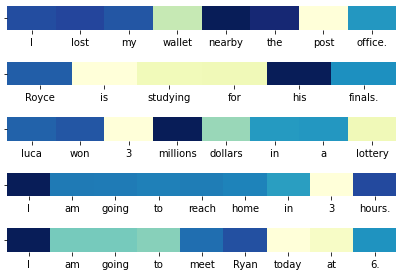

In [ ]:
sentences = ["I lost my wallet nearby the post office.",
             "Royce is studying for his finals.",
             "luca won 3 millions dollars in a lottery",
             "I am going to reach home in 3 hours.",
             "I am going to meet Ryan today at 6."
             ]

figure = None
figure = show(sentences)
#figure.savefig('graphs/stressed.pdf', format='pdf', dpi=300)

In [ ]:
name="history_multihead_att.txt"
with open(name, 'w+') as f:
  for value in history2.history["accuracy"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")
  for value in history2.history["val_accuracy"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")
  for value in history2.history["loss"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")
  for value in history2.history["val_loss"]:
    f.write(str(value))
    f.write("\n")
  f.write("\n")

f.close()

